# MÉRA preprocess in order to work with lighter files and right projections

### Different imports

In [1]:
import numpy as np
import geopandas
import pandas
import shapely.geometry, shapely.wkt
import matplotlib.pyplot as plt
from osgeo import osr, ogr
import time
from datetime import datetime

### Ireland map with GADM data

<Figure size 432x288 with 0 Axes>

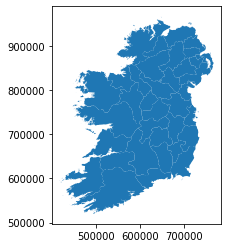

In [2]:
pandasSouth = geopandas.read_file('gadm36_IRL_1.shp')
pandasNorth = geopandas.read_file('gadm36_GBR_2.shp')

pandasSouth = geopandas.GeoDataFrame(pandasSouth, crs={'init':'epsg:4326'}, geometry='geometry')
pandasSouth = pandasSouth.to_crs({'init':'epsg:2157'})

pandasNorth = geopandas.GeoDataFrame(pandasNorth, crs={'init':'epsg:4326'}, geometry='geometry')
pandasNorth = pandasNorth.to_crs({'init':'epsg:2157'})

pandasNorth = pandasNorth.query("NAME_1 == 'Northern Ireland'")

pandasIreland = pandas.concat([pandasSouth, pandasNorth], join='inner')

plt.figure()
pandasIreland.plot()
plt.show()

### Read filtered Agristats data

<Figure size 432x288 with 0 Axes>

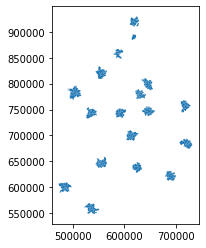

In [3]:
pandasFilteredAgristats = pandas.read_csv('AgristatsSimplified.txt', sep=';')
pandasFilteredAgristats['geometry'] = pandasFilteredAgristats['geometry'].apply(shapely.wkt.loads)
pandasFilteredAgristats = geopandas.GeoDataFrame(pandasFilteredAgristats, crs={'init':'epsg:2157'}, geometry='geometry')

plt.figure()
pandasFilteredAgristats.plot()
plt.show()

### Read MÉRA data from .txt file

In [4]:
# à tester avec skip_rows et lecture des lignes en file.open

tic = time.time()

columnsName = ['Latitude', 'Longitude', 'Value', 'dataDate', 'dataTime', 'validityDate', 'validityTime']
columnsType = {'Latitude': float, 'Longitude': float, 'Value': float, 'dataDate': int, 'dataTime': int,
               'validityDate': int, 'validityTime': int}

fileName = 'TotalPrecip_2017_01.txt'

pandasClimate = pandas.read_csv(fileName, delim_whitespace=True, names=columnsName,
                               na_values=['Latitude,', 'Longitude,', 'Value,', 'dataDate,', 'dataTime,', 'validityDate,', 'validityTime'])
pandasClimate = pandasClimate.dropna()
pandasClimate = pandasClimate.astype(columnsType)

tac = time.time()

print ('Reading time: {} seconds\n'.format(round(tac-tic,3)))
print (pandasClimate)

Reading time: 5.596 seconds

         Latitude  Longitude     Value  dataDate  dataTime  validityDate  \
1          46.834    345.391  0.000000  20170101         0      20170102   
2          46.840    345.422  0.000000  20170101         0      20170102   
3          46.846    345.454  0.000000  20170101         0      20170102   
4          46.852    345.485  0.000000  20170101         0      20170102   
5          46.858    345.517  0.000000  20170101         0      20170102   
...           ...        ...       ...       ...       ...           ...   
8019137    59.598      1.965  0.054298  20170131         0      20170201   
8019138    59.599      2.010  0.056274  20170131         0      20170201   
8019139    59.600      2.054  0.057266  20170131         0      20170201   
8019140    59.601      2.098  0.058250  20170131         0      20170201   
8019141    59.602      2.142  0.058250  20170131         0      20170201   

         validityTime  
1                 900  
2         

In [5]:
# Filters the data to keep values on simply one day (just to easily experiment dataset)

#pandasClimate = pandasClimate[(pandasClimate.dataDate == list(pandasClimate.dataDate)[0])]
#print (pandasClimate)

### Projects MÉRA data from WGS84 to IRENET95

In [6]:
#pandasClimate.loc[pandasClimate['Longitude'] > 180, 'Longitude'] -= 360
#
#geometry = [shapely.geometry.Point(lonlat) for lonlat in zip(pandasClimate.Longitude, pandasClimate.Latitude)]
#geoClimate = geopandas.GeoDataFrame(pandasClimate, crs={'init': 'epsg:4326'}, geometry=geometry)
#
#geoClimate = geoClimate.to_crs({'init': 'epsg:2157'})
#
#plt.figure()
#geoClimate.plot()
#plt.show()

In [7]:
#geometry = [shapely.geometry.Point(lonlat) for lonlat in zip(pandasClimate.Longitude, pandasClimate.Latitude)]
#
#source = osr.SpatialReference()
#source.ImportFromEPSG(4326)
#
#target = osr.SpatialReference()
#target.ImportFromEPSG(2157)
#
#transform = osr.CoordinateTransformation(source, target)
#
#for i in range (len(geometry)):
#    point = ogr.CreateGeometryFromWkt(str(geometry[i]))
#    point.Transform(transform)
#    projPoint = point.ExportToWkt().split()
#    geometry[i] = shapely.geometry.Point(float(projPoint[1][1::]), float(projPoint[2][:-1:]))
#
#geoClimate = geopandas.GeoDataFrame(pandasClimate, crs={'init':'epsg:2157'}, geometry=geometry)
#
#plt.figure()
#geoClimate.plot()
#plt.show()

Projection time: 324.452 seconds


<Figure size 432x288 with 0 Axes>

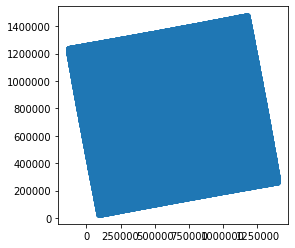

In [8]:
tic = time.time()

prj_txt = """GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]"""

srs = osr.SpatialReference()
srs.ImportFromESRI([prj_txt])

proj4Value = srs.ExportToProj4()

# The creation of the list geometry has to be improve if possible
geometry = [shapely.geometry.Point(lonlat) for lonlat in zip(pandasClimate.Longitude, pandasClimate.Latitude)]
geoClimate = geopandas.GeoDataFrame(pandasClimate, crs=proj4Value, geometry=geometry)

#geoClimate = geopandas.GeoDataFrame(pandasClimate, crs=proj4Value, geometry=geopandas.points_from_xy(pandasClimate.Longitude, pandasClimate.Latitude))

geoClimate = geoClimate.to_crs({'init': 'epsg:2157'})

tac = time.time()
print ('Projection time: {} seconds'.format(round(tac-tic, 3)))

plt.figure()
geoClimate[(pandasClimate.dataDate == list(pandasClimate.dataDate)[0])].plot()
plt.show()

### Recuperate boundaries of Ireland to have a first coarse filtering

<Figure size 432x288 with 0 Axes>

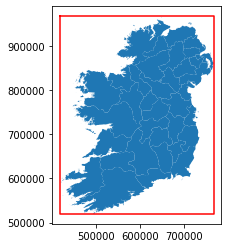

In [9]:
minx = min(pandasIreland.geometry.bounds.minx)
miny = min(pandasIreland.geometry.bounds.miny)
maxx = max(pandasIreland.geometry.bounds.maxx)
maxy = max(pandasIreland.geometry.bounds.maxy)

polyIreland = shapely.geometry.Polygon([[minx,maxy], [maxx,maxy], [maxx,miny], [minx,miny]])

plt.figure()
pandasIreland.plot()
plt.plot(*polyIreland.exterior.xy, 'r')
plt.show()

<Figure size 432x288 with 0 Axes>

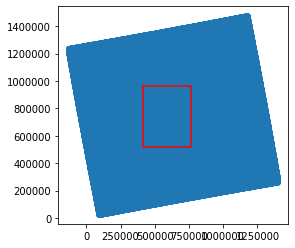

In [10]:
plt.figure()
geoClimate[(pandasClimate.dataDate == list(pandasClimate.dataDate)[0])].plot()
plt.plot(*polyIreland.exterior.xy, 'r')
plt.show()

Length before filtering: 8019111
              and after: 771001

Filtering time: 46.784 seconds


C:\Users\gabin\Anaconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


<Figure size 432x288 with 0 Axes>

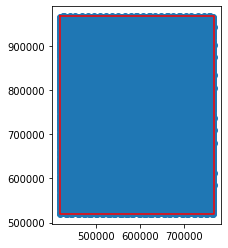

In [11]:
tic = time.time()

print ('Length before filtering: {}'.format(len(geoClimate)))

geoClimate = geoClimate.loc[geoClimate['geometry'].within(polyIreland)]

print ('              and after: {}\n'.format(len(geoClimate)))

tac = time.time()
print ('Filtering time: {} seconds'.format(round(tac-tic, 3)))

plt.figure()
geoClimate[(pandasClimate.dataDate == list(pandasClimate.dataDate)[0])].plot()
plt.plot(*polyIreland.exterior.xy, 'r')
plt.show()

### Second filtering with Agristats regions

In [12]:
#print (geoClimate.loc[any(geoClimate['geometry'].within(pandasFilteredAgristats['geometry']))])

polygonsAgristats = pandasFilteredAgristats['geometry'].values
#multiAgristats = shapely.geometry.MultiPolygon(polygonsAgristats)

In [13]:
tic = time.time()

for pol in polygonsAgristats:

    if pol == polygonsAgristats[0]:
        indexes = geoClimate['geometry'].within(pol)
    else:
        transition = (geoClimate['geometry'].within(pol))
        indexes[transition.loc[transition == True].index] = True

tac = time.time()
print ('Filtering time: {} seconds'.format(round(tac-tic, 3)))

Filtering time: 645.111 seconds


In [14]:
filteredClimate = geoClimate[indexes]

print ('Length before filtering: {}\n              and after: {}'.format(len(geoClimate), len(filteredClimate)))

Length before filtering: 771001
              and after: 22072


<Figure size 432x288 with 0 Axes>

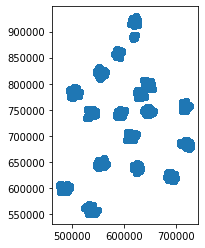

In [15]:
plt.figure()
filteredClimate.plot()
plt.show()

### Save new MÉRA data

In [16]:
filteredClimate.to_csv('{}_Simplified{}'.format(fileName[:-4:], fileName[-4::]), index=False)